# Example: Virtual Detector with Visualization in HyperSpy

An example how to process a pixelated STEM dataset from an HDFS filesystem. 

Prerequisites: 

 * a python3.6 virtualenv with all requirements installed
  * ``pip install -e .`` in your LiberTEM source dir
  * ``pip install hyperspy hyperspy_gui_ipywidgets hdfs3`` for additional dependencies
  * hdfs3 might need some care as it depends on libhdfs3 which needs to be built first...
 * a running HDFS installation (single node is fine)
 * a dataset imported onto the HDFS filesystem with the ``ingest`` prototype
  * example call: ``$ python ingest.py ~/Data/EMPAD/scan_11_x256_y256.emd experimental/science_data/data test/``
  * ``experimental/science_data/data`` is the path to the HDF5 DataSet that contains your data, ``test/`` is the destination on the Hadoop filesystem

In [1]:
%matplotlib nbagg

We disable threading in OpenBLAS because it would interfere with the dask multiprocessing and because OpenBLAS likes to call ``sched_yield`` for no discernable reason

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

Import our dependencies. There may be some warnings about ``hyperspy_gui_traitui`` and so on which can be safely ignored (you do need ``hyperspy_gui_ipywidgets`` though):

In [3]:
from libertem.dataset.hdfs import BinaryHDFSDataSet
from libertem.executor.dask import DaskJobExecutor
from libertem.job.masks import ApplyMasksJob
from libertem.utils import _make_circular_mask
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt

/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now onto our masks. Many problems in pixelated STEM can be solved by element-wise matrix multiplication and summation of a mask onto each frame, including virtual detector. Here we define some simple radial masks: 

<IPython.core.display.Javascript object>


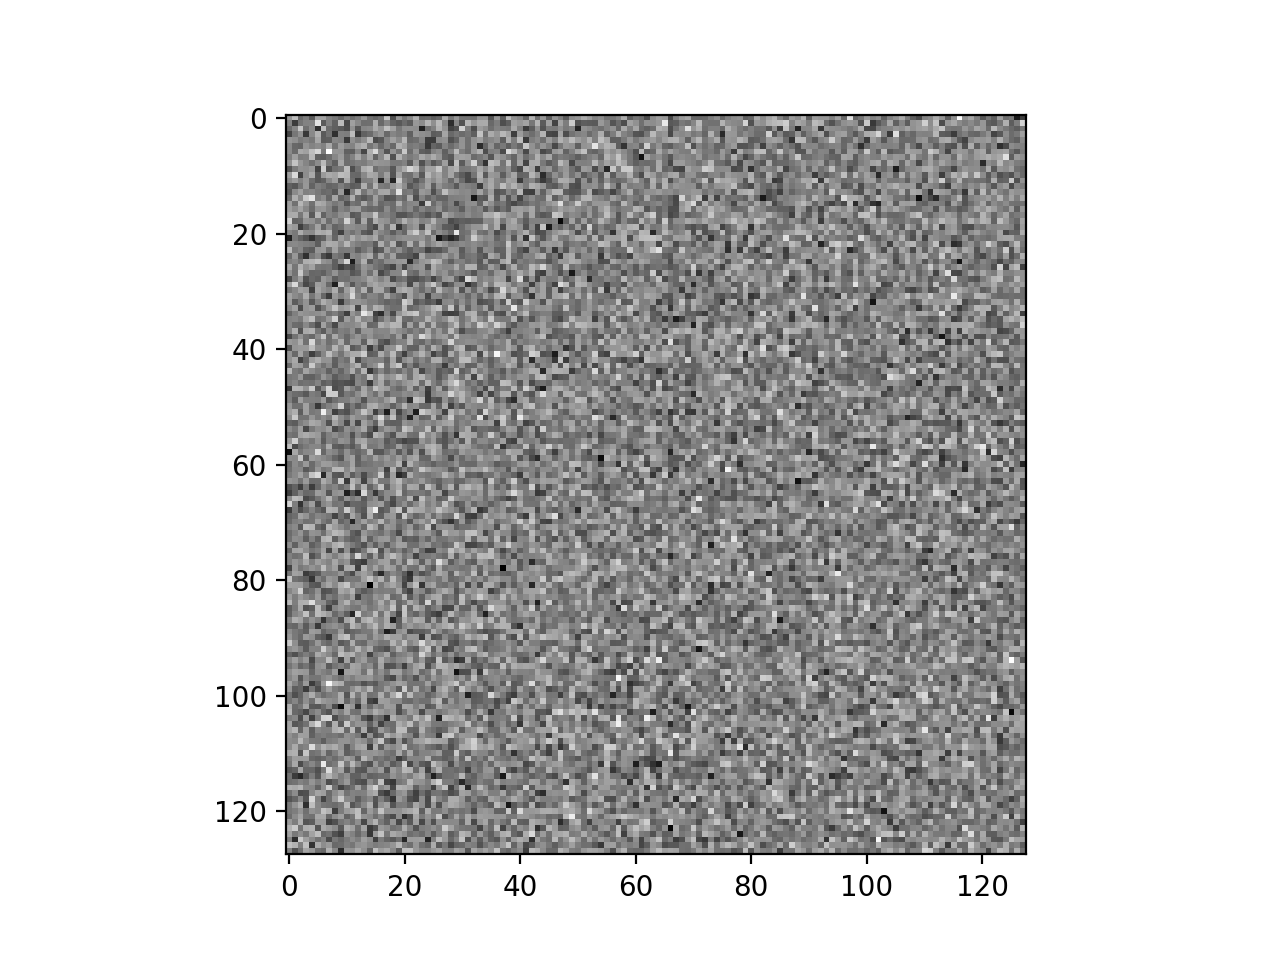

<IPython.core.display.Javascript object>


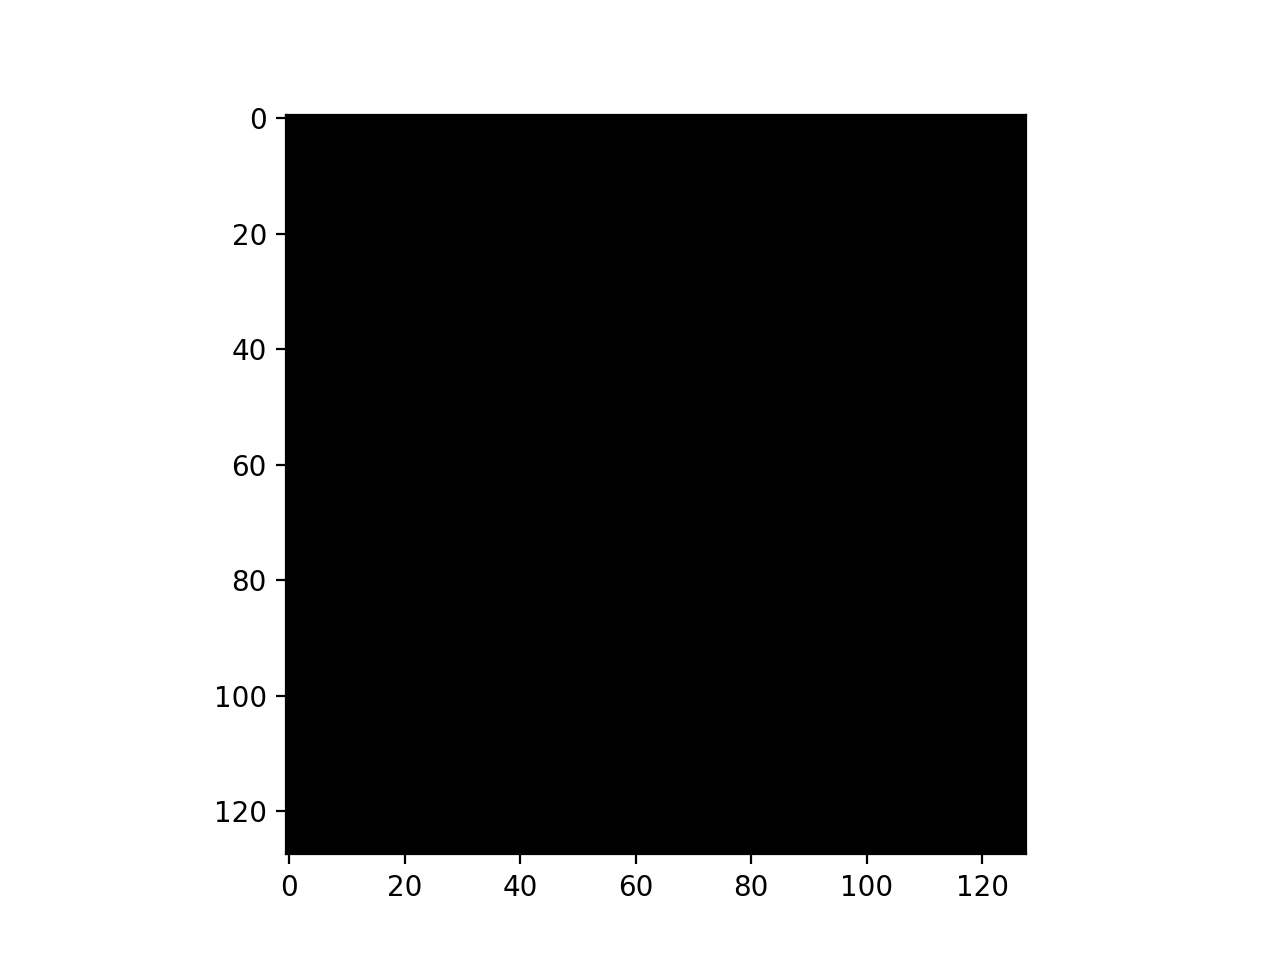

<IPython.core.display.Javascript object>


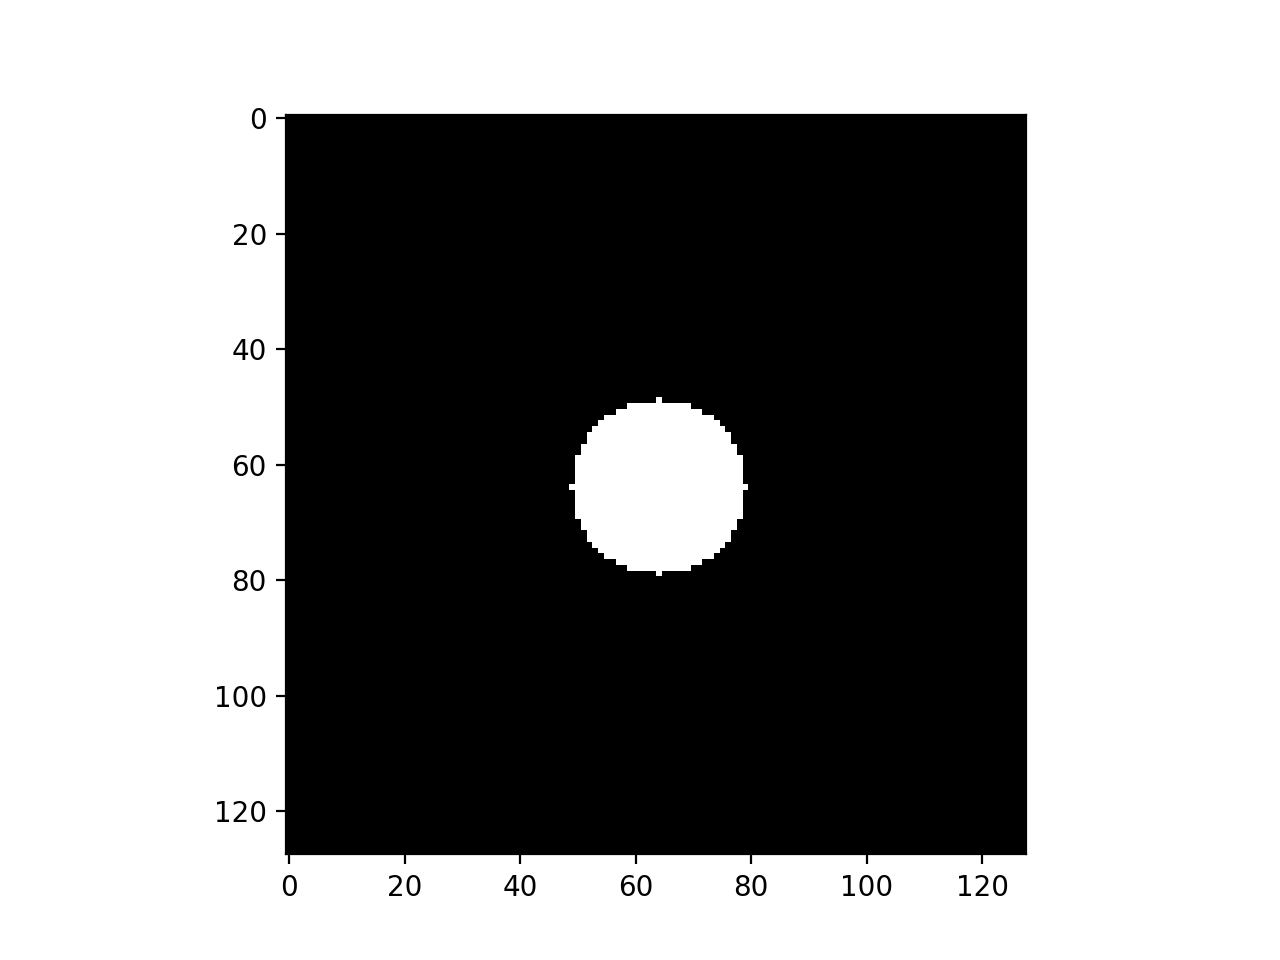

<IPython.core.display.Javascript object>


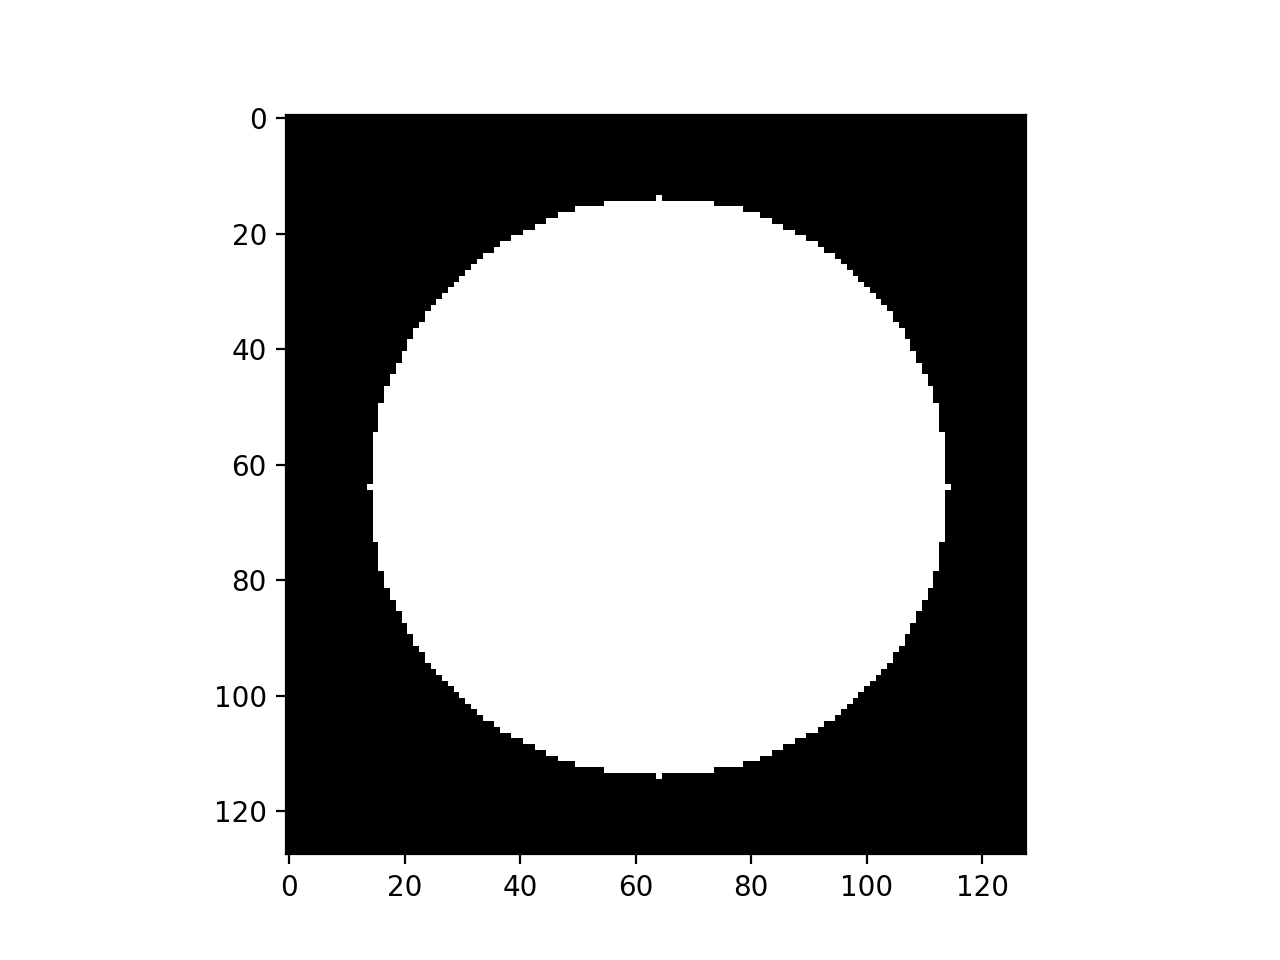

<IPython.core.display.Javascript object>


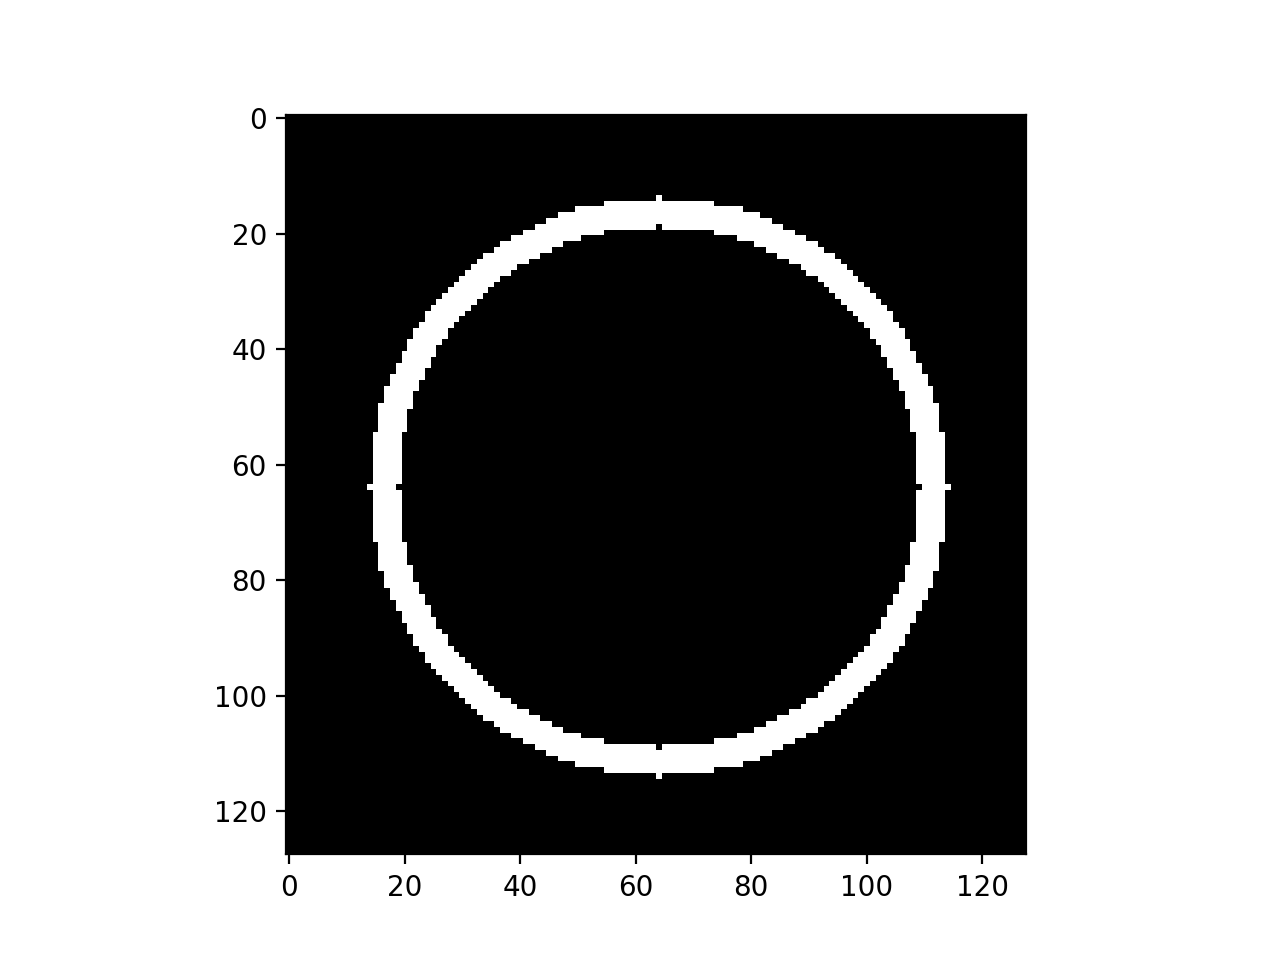

In [4]:
masks=[
    # random noise for comparison
    np.random.randn(128, 128),
    
    # summation of all pixels:
    np.ones(shape=(128, 128)),
    
    # small radial mask at the center of the frame:
    np.ones(shape=(128, 128)) * _make_circular_mask(
        centerX=64, centerY=64,
        imageSizeX=128, imageSizeY=128, radius=15
    ),
    
    # large radial mask:
    np.ones(shape=(128, 128)) * _make_circular_mask(
        centerX=64, centerY=64,
        imageSizeX=128, imageSizeY=128, radius=50
    ),
    
    # ring, built from a large radial mask minus a smaller radial mask:
    np.ones(shape=(128, 128)) * (
        _make_circular_mask(
            centerX=64, centerY=64,
            imageSizeX=128, imageSizeY=128, radius=50
        ) &
        (~_make_circular_mask(
            centerX=64, centerY=64,
            imageSizeX=128, imageSizeY=128, radius=45
        ))
    ),
]

# visualize all masks:
for mask in masks:
    fig, axes = plt.subplots()
    axes.imshow(mask)

Here we define the ``stackheight``. It says how many frames we process at once. Our dataset has ``128×128`` frames at 8 bytes per pixel, so 8 frames are exactly 1 MB. As my laptop CPU has a L3 cache with a capacity of 8MB, using 4 threads means the working set fits into the L3 cache, even with room for about 32 masks.

In [5]:
stackheight = 8

Using ``BinaryHDFSDataSet`` we define the input dataset including parameters for connecting to the HDFS namenode, and the ``stackheight`` we set above. With ``ApplyMasksJob`` we define the operation we want to do on the dataset: apply masks. Finally, with ``DaskJobExecutor`` we define the execution environment - we want to use dask in this case, with a scheduler running on the local computer.

In [6]:
ds = BinaryHDFSDataSet(index_path="test/index.json", host='localhost', port=8020, stackheight=stackheight)
job = ApplyMasksJob(dataset=ds, masks=masks)  # if you want to test with just a single mask, pass masks[-1:] to select just the last one

executor = DaskJobExecutor.make_local(cluster_kwargs={})

# we use a local cluster here, if you want to use a real cluster, use the following line instead:
# executor = DaskJobExecutor(scheduler_uri="tcp://localhost:8786")

# print(executor.client.scheduler_info())

Now, we define a HyperSpy signal that will hold our result. The navigation axis will select the result for a specific mask, and the signal axis is the 256×256 result image.

<IPython.core.display.Javascript object>


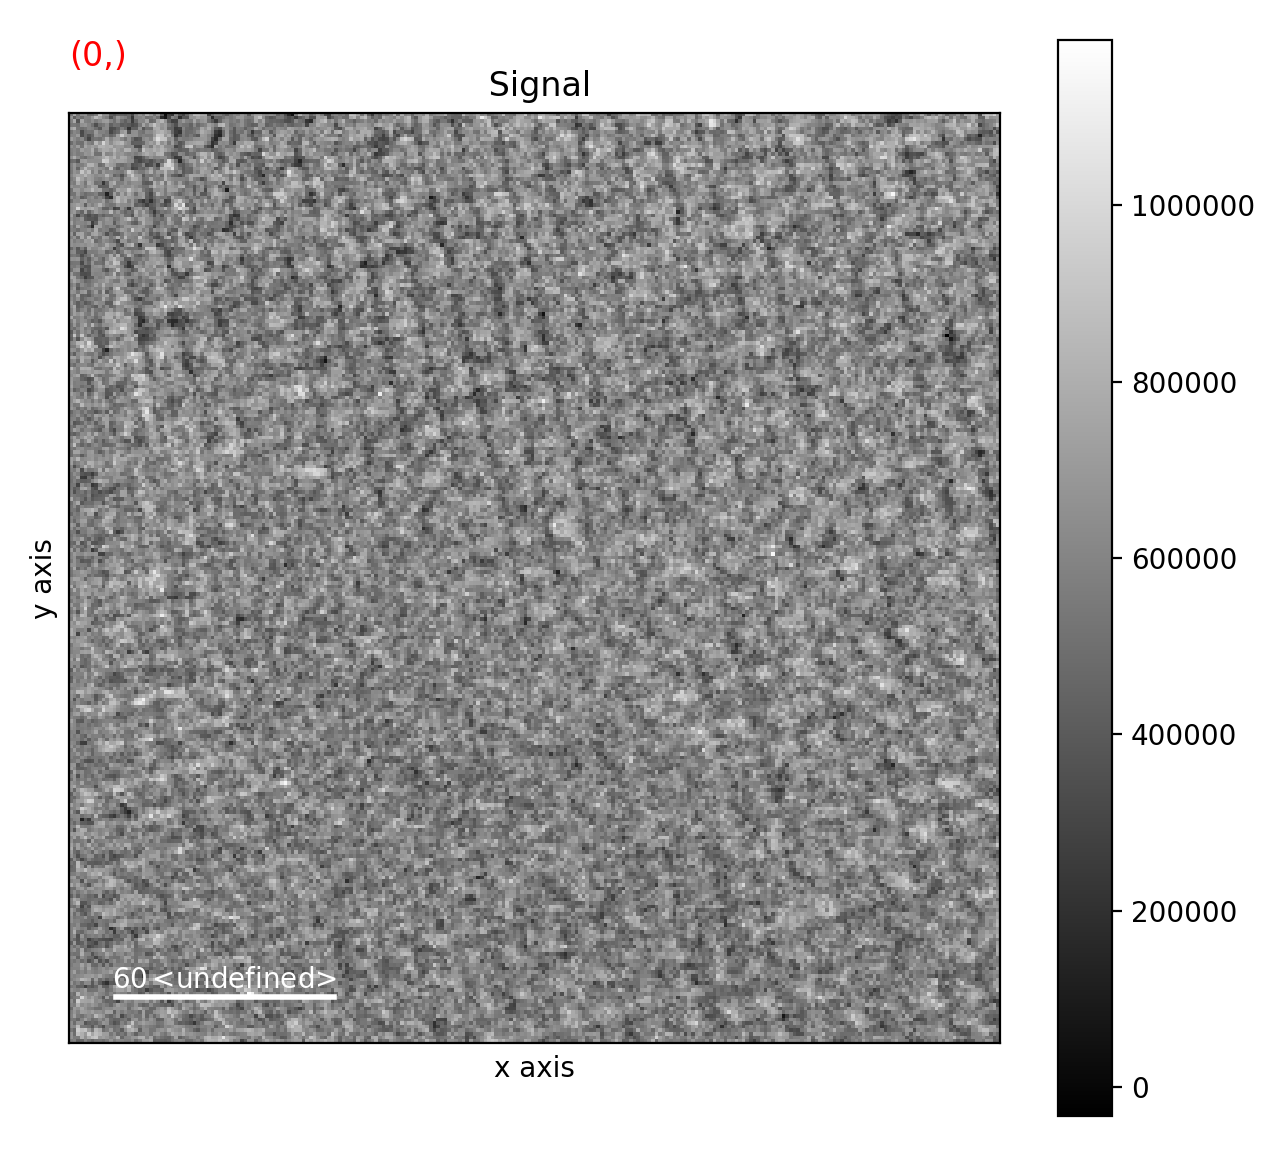

In [7]:
full_result = hs.signals.Signal2D(np.zeros(shape=(job.maskcount, 256, 256)))
full_result.axes_manager[0].name = "masks"
full_result.axes_manager[1].name = "x"
full_result.axes_manager[2].name = "y"
full_result.plot(navigator="slider")

In [8]:
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=len(list(job.get_tasks())))
display(f)
full_result.data = np.zeros(shape=(job.maskcount, 256, 256))
full_result.events.data_changed.trigger(full_result)
full_result._plot.signal_plot.figure.canvas.draw()

FloatProgress(value=0.0, max=16.0)

Now, for kicking off the computation, we tell the ``executor`` to run ``job``. ``run_job`` is a generator and we get the results back as they arrive from the dask scheduler. Each ``result`` is a list of ``ResultTile`` instances, and each ``tile`` represents the result of all masks applied to ``stackheight`` frames. Each ``ResultTile`` knows where in the ``full_result`` it should end up, so we ask it via ``copy_to_result`` to copy its data to the HyperSpy signal data array. We then trigger the ``data_changed`` HyperSpy event, which should enable live updates for results as they come in.

In [9]:
f.value = 0
def run():
    for result in executor.run_job(job):
        for tile in result:
            tile.copy_to_result(full_result.data)
        # updating the whole canvas is expensive, but gives us live feedback:
        # full_result._plot.signal_plot.figure.canvas.draw()
        f.value += 1
    full_result.events.data_changed.trigger(full_result)
    return tile
%time tile = run()

CPU times: user 640 ms, sys: 118 ms, total: 758 ms
Wall time: 1.53 s


Nice! With a warm fs cache, LiberTEM can apply 5 masks to the 8GB dataset in about 1.28s (for a single mask, we only take ~800ms).

Let's have a look at one of the result tiles:

In [10]:
tile

<ResultTile for slice=<Slice origin=(223, 248, 0, 0) shape=(1, 8, 128, 128)>>

The ``origin`` tells us where in the full dataset this tile originated, and ``shape`` tells us the shape of the *source ``DataTile``* that was processed into this ``ResultTile`` (more on ``DataTile`` later).

In [11]:
tile.data.shape

(8, 5)

Here we can see that the source ``DataTile`` that contained 8 frames with a shape of ``(1, 8, 128, 128)`` had 6 masks applied to it and thus was reduced to a shape of ``(8, 6)``. 

## Data Partitioning

For distributing the computation, we also have to distribute the data. For that, the ``ingest`` script slices the data into partitions. Let's have a look at them:

In [12]:
[p.slice for p in ds.get_partitions()]

[<Slice origin=(0, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(16, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(32, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(48, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(64, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(80, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(96, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(112, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(128, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(144, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(160, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(176, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(192, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(208, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(224, 0, 0, 0) shape=(16, 256, 128, 128)>,
 <Slice origin=(240, 0, 0, 0) shape=(16, 256, 128, 128)>]

So our dataset is neatly sliced in the first dimension, each partition containing ``16*256 = 4096`` frames. We can also take a look at the index, as it is stored on HDFS:

In [13]:
ds._index

{'dtype': 'float64',
 'mode': 'rect',
 'shape': [256, 256, 128, 128],
 'partitions': [{'origin': [0, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000000.raw'},
  {'origin': [16, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000001.raw'},
  {'origin': [32, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000002.raw'},
  {'origin': [48, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000003.raw'},
  {'origin': [64, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000004.raw'},
  {'origin': [80, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000005.raw'},
  {'origin': [96, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000006.raw'},
  {'origin': [112, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000007.raw'},
  {'origin': [128, 0],
   'shape': [16, 256, 128, 128],
   'filename': 'partition-00000008.raw'},
  {'origin': [144, 0],
   'shape': [16, 25

Now, for efficient computation, each partition itself is split into even smaller ``DataTile``s that fit into the L3 cache:

In [14]:
p = next(ds.get_partitions())
data_tile = next(p.get_tiles())

In [15]:
data_tile

<DataTile <Slice origin=(0, 0, 0, 0) shape=(1, 8, 128, 128)>>

So each ``DataTile`` contains ``stackheight`` frames, each of which is 128x128

In [16]:
len(list(ds.get_partitions()))

16

In [17]:
len(list(p.get_tiles()))

512